In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## **[TFRecord and tf.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord#fetch_the_images)**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

%tensorflow_version 2.x
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

AUTOTUNE = tf.data.experimental.AUTOTUNE

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  0
GPU device not found


In [ ]:
import pathlib
project_dir = "/content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/"
oral_cancer_dataset_dir = project_dir + "OralCancer_DataSet3/"
train_dir = pathlib.Path(oral_cancer_dataset_dir + "train/")
test_dir = pathlib.Path(oral_cancer_dataset_dir + "test/")

CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
total_train = 73303  # len(list(train_dir.glob('*/*/*.jpg')))  # 73303
total_test = 55514  # len(list(test_dir.glob('*/*/*.jpg')))  # 55514

BATCH_SIZE = 128
epochs = 30
IMG_HEIGHT = 80
IMG_WIDTH = 80

# from IPython.display import display
# image_example_dir = str(list(train_dir.glob('Cancer/000/*.jpg'))[0])
# display(Image.open(image_example_dir))

## **Fetch the images**

In [ ]:
train_list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*/*'))
test_list_ds = tf.data.Dataset.list_files(str(test_dir/'*/*/*'))
# for f in train_list_ds.take(5):
#   print(f.numpy())

def process_path(file_path):

  def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)  # convert the path to a list of path components
    return int(parts[-3] == CLASS_NAMES[0]) # The third to last is the class-directory

  label = get_label(file_path)
  img = tf.io.read_file(file_path)  # load the raw data from the file as a string
  # img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 22:15 ~
test_labeled_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# for image, label in train_labeled_ds.take(1):
#   print("Image shape: ", image.numpy().shape)
#   print("Label: ", label.numpy())

## **Write the TFRecord file**

In [ ]:
def image_example(image_string, label):
  def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
      value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

  def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
  
  feature = {
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string)}
  return tf.train.Example(features=tf.train.Features(feature=feature))

# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.Example` messages.
# Then, write to a `.tfrecords` file.
print("Starting writing data...")
i = 0
train_record_file = oral_cancer_dataset_dir + 'train_images.tfrecords'
test_record_file = oral_cancer_dataset_dir + 'test_images.tfrecords'
with tf.io.TFRecordWriter(train_record_file) as writer:
  for (image_string, label) in train_labeled_ds:
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())
    if i % 1000 == 0:
      print(i)
    i += 1
with tf.io.TFRecordWriter(test_record_file) as writer:
  for (image_string, label) in test_labeled_ds:
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())
    if i % 1000 == 0:
      print(i)
    i += 1

## **Read the TFRecord file**

In [ ]:
oral_cancer_dataset_dir = "/content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/OralCancer_DataSet3/"
## train_record_file = oral_cancer_dataset_dir + 'train_images.tfrecords'
test_record_file = oral_cancer_dataset_dir + 'test_images.tfrecords'

## train_image_dataset = tf.data.TFRecordDataset(train_record_file)
test_image_dataset = tf.data.TFRecordDataset(test_record_file)
# Create a dictionary describing the features.
image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

## train_ds = train_image_dataset.map(_parse_image_function)
test_ds = test_image_dataset.map(_parse_image_function)

tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xdb\x00C\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\xff\xc0\x00\x11\x08\x00P\x00P\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3b

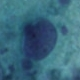

In [ ]:
# Example
import IPython.display as display

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)  # convert the compressed string to a 3D uint8 tensor
  return tf.image.convert_image_dtype(img, tf.float32)  # Use `convert_image_dtype` to convert to floats in the [0,1] range.

for a in test_ds.take(1):
  print(a['image_raw'])
  raw_image = a['image_raw'].numpy()
  label = a['label'].numpy()
  print(label)
  # print(decode_img(raw_image))
  display.display(display.Image(raw_image))